In [46]:
%matplotlib inline
from __future__ import division, print_function

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from folder_manipulations import mkdir_p
import gc_colors
import pandas as pd
import glob
import re
import os
import STUDENT
import TBFunctions as TB
import danplotlib as dpl
import numpy as np
import scipy.stats as stats
from Clusteralgorithm import cluster_algorithm
from Clustering import cluster_algo_settings

plt.style.use("latex")
gc_colors.update_colorcycle()

# Clusteralgorithm settings

In [3]:
cluster_algo_settings

{'Big': {'continue_th': 1, 'min_size': 2, 'seed_th': 2, 'single_ch_th': 3},
 'Default': {'min_size': 2, 'seed_th': 2, 'single_ch_th': 3},
 'No_requirements': {'min_size': 0, 'seed_th': 2, 'single_ch_th': 0},
 'Seed_1': {'min_size': 0, 'seed_th': 1, 'single_ch_th': 0}}

# List all available files

In [5]:
DF_all_files = TB.Files_DF("/auto/data/berninghoff/tb2017_1_Output/Preselection/*/*.root")
DF_all_files.iloc[:,:0:-1]

Filename_short  Position  ThSetting  IntSetting  \
0  2.0GeV_setting4.2_000mm_1_noComment.root         0          2           4   
1  2.0GeV_setting4.1_000mm_1_noComment.root         0          1           4   
2  2.0GeV_setting4.3_000mm_1_noComment.root         0          3           4   

   Beamenergy  Layer  
0         2.0      0  
1         2.0      0  
2         2.0      0

# Choose subset of files and read in data & clusters

In [6]:
cluster_algorithms = [ "Default" ]

settings = { "Layer" : [0],
             "Beamenergy" : [2.0], #GeV
             "Position" : [0], #mm
             "IntSetting" : [4],
             "ThSetting" : [1,2,3],
             "inFilename" : "1_noComment"}

selection = None
chunksize = None

DF_selected_files = TB.filter_files(DF_all_files, settings)
DF_selected_files = TB.read_data(DF_selected_files, selection, cluster_algorithms, chunksize)
DF_selected_files

Reading in data from  /auto/data/berninghoff/tb2017_1_Output/Preselection/Layer_0/tb2017_1_pacific_2.0GeV_setting4.2_000mm_1_noComment.root
Found clusterfiles:  ['/auto/data/berninghoff/tb2017_1_Output/Preselection/Layer_0/Clusters/Default/tb2017_1_pacific_2.0GeV_setting4.2_000mm_1_noComment.h5', '/auto/data/berninghoff/tb2017_1_Output/Preselection/Layer_0/Clusters/No_requirements/tb2017_1_pacific_2.0GeV_setting4.2_000mm_1_noComment.h5', '/auto/data/berninghoff/tb2017_1_Output/Preselection/Layer_0/Clusters/Big/tb2017_1_pacific_2.0GeV_setting4.2_000mm_1_noComment.h5', '/auto/data/berninghoff/tb2017_1_Output/Preselection/Layer_0/Clusters/Seed_1/tb2017_1_pacific_2.0GeV_setting4.2_000mm_1_noComment.h5']
Reading clusters for algorithm Default from /auto/data/berninghoff/tb2017_1_Output/Preselection/Layer_0/Clusters/Default/tb2017_1_pacific_2.0GeV_setting4.2_000mm_1_noComment.h5
Merge to existing Dataframe (column: Clusters_Default)
After merge 1604236 events of 1604236 remain.
Reading in da

Filename  Layer  Beamenergy  \
0  /auto/data/berninghoff/tb2017_1_Output/Presele...      0         2.0   
1  /auto/data/berninghoff/tb2017_1_Output/Presele...      0         2.0   
2  /auto/data/berninghoff/tb2017_1_Output/Presele...      0         2.0   

   IntSetting  ThSetting  Position                            Filename_short  \
0           4          2         0  2.0GeV_setting4.2_000mm_1_noComment.root   
1           4          1         0  2.0GeV_setting4.1_000mm_1_noComment.root   
2           4          3         0  2.0GeV_setting4.3_000mm_1_noComment.root   

                                           Dataframe  
0           Evt_num     Run_num    Timestamp  Lay...  
1           Evt_num     Run_num   Timestamp  Laye...  
2           Evt_num     Run_num    Timestamp  Lay...

# Plot aggregated signalshape for only the channels central of a cluster

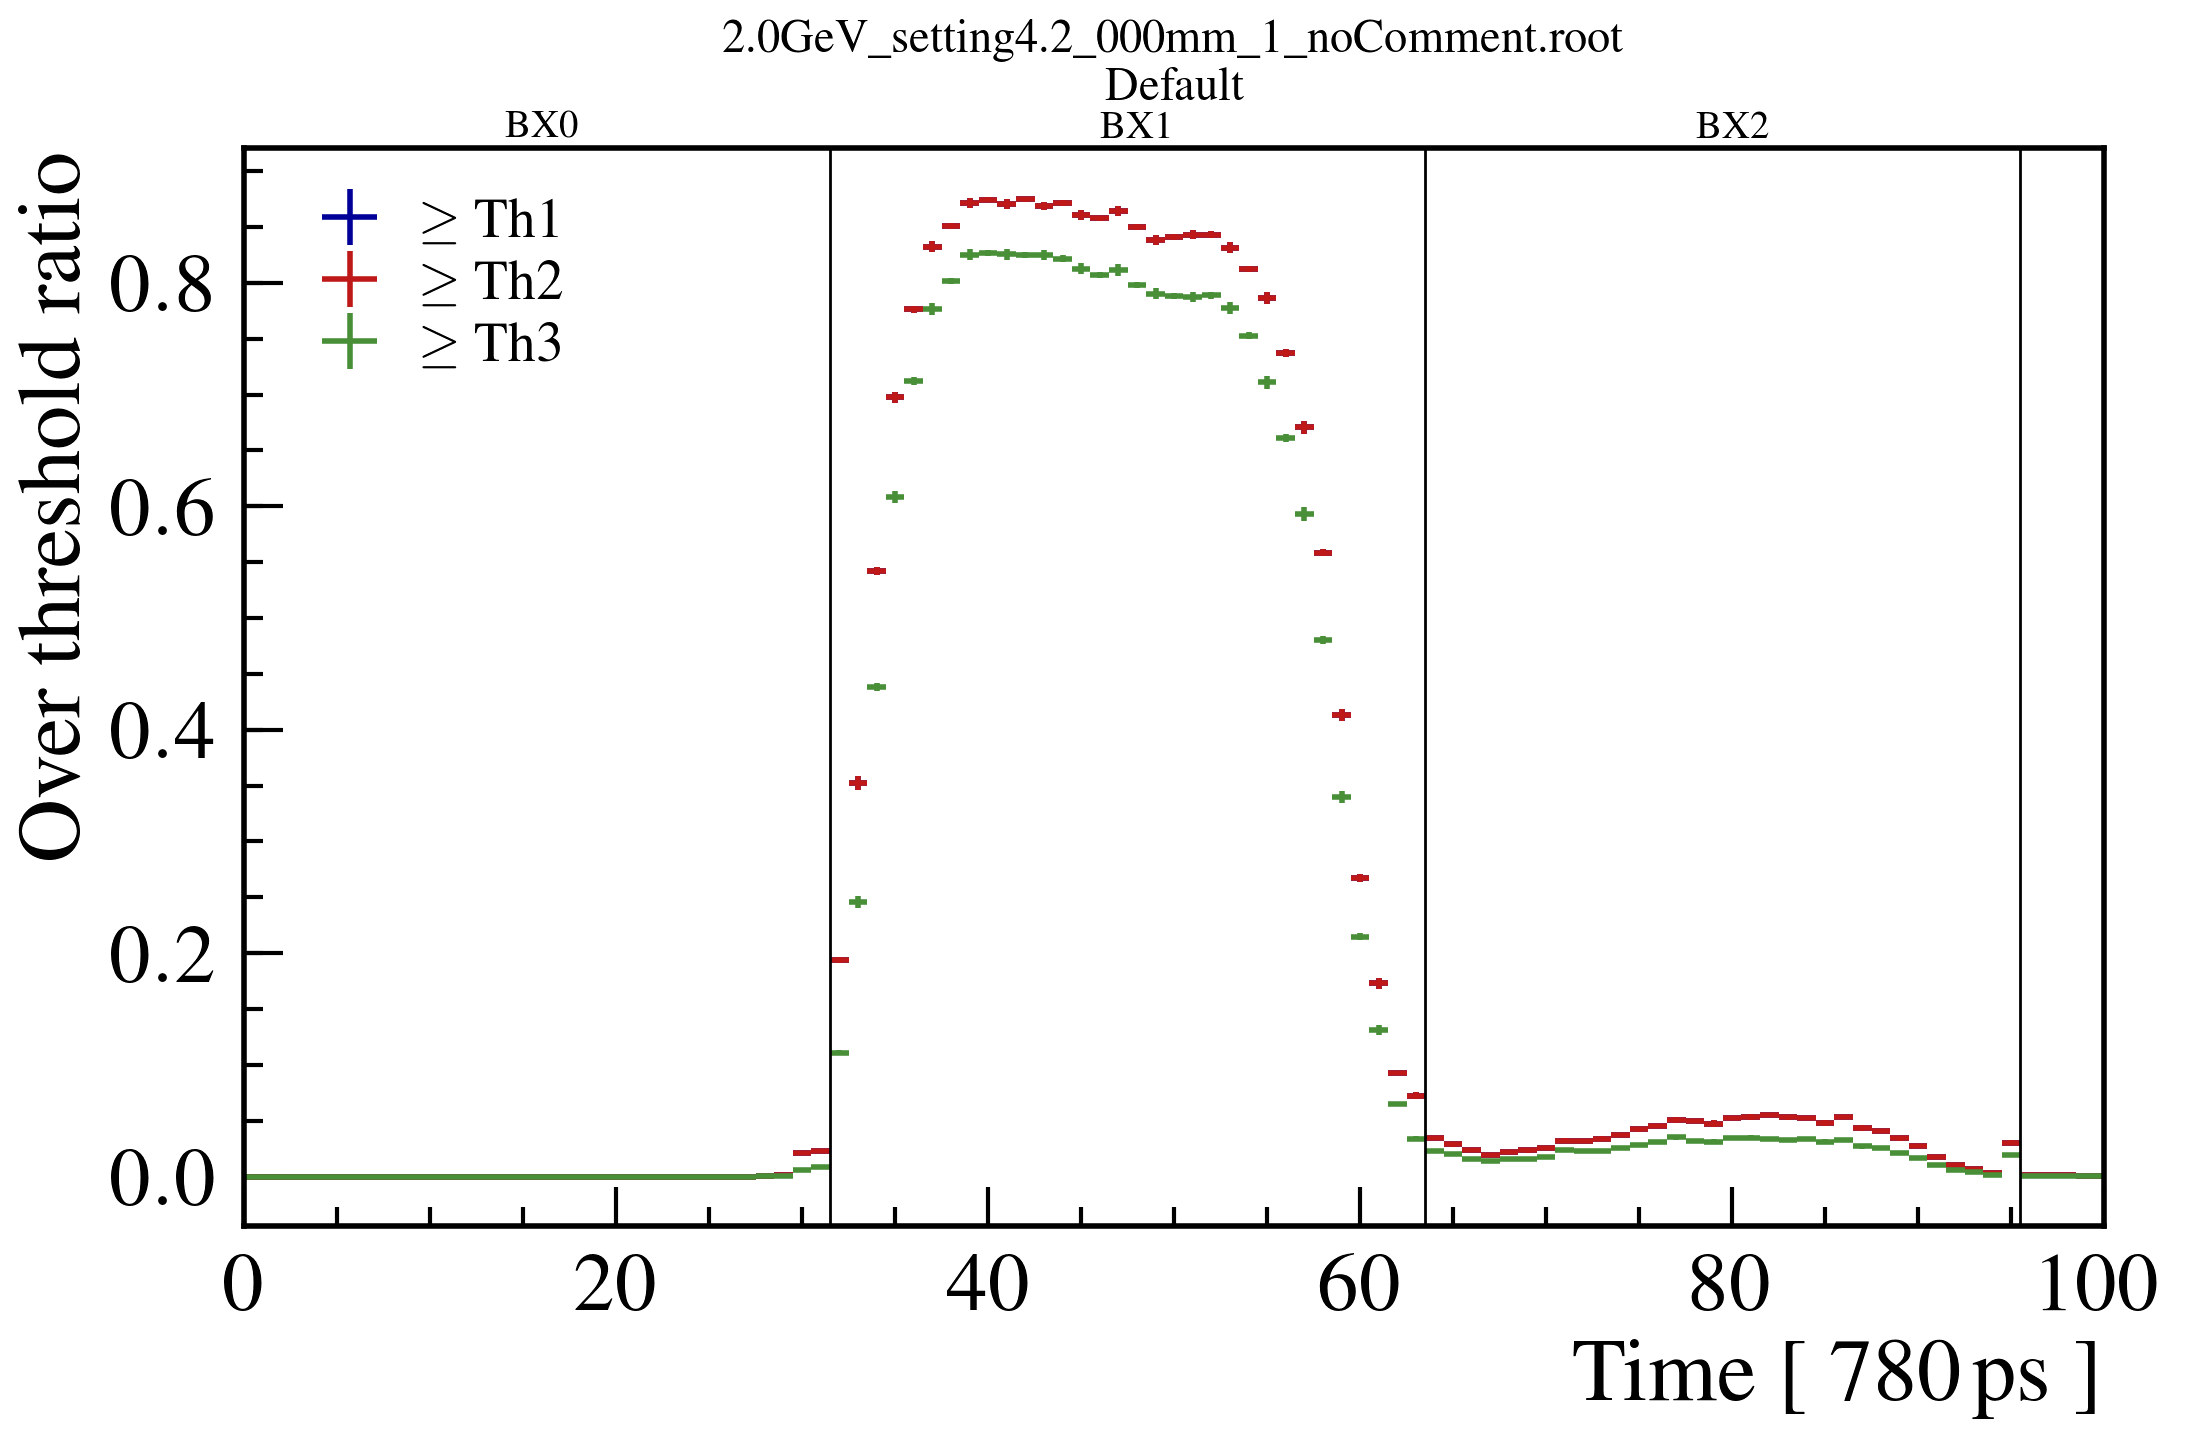

Saved 2.0GeV_setting4.2_000mm_1_noComment.root, Default to Plots/Signalshape_clusterchannels/Signalshape.pdf


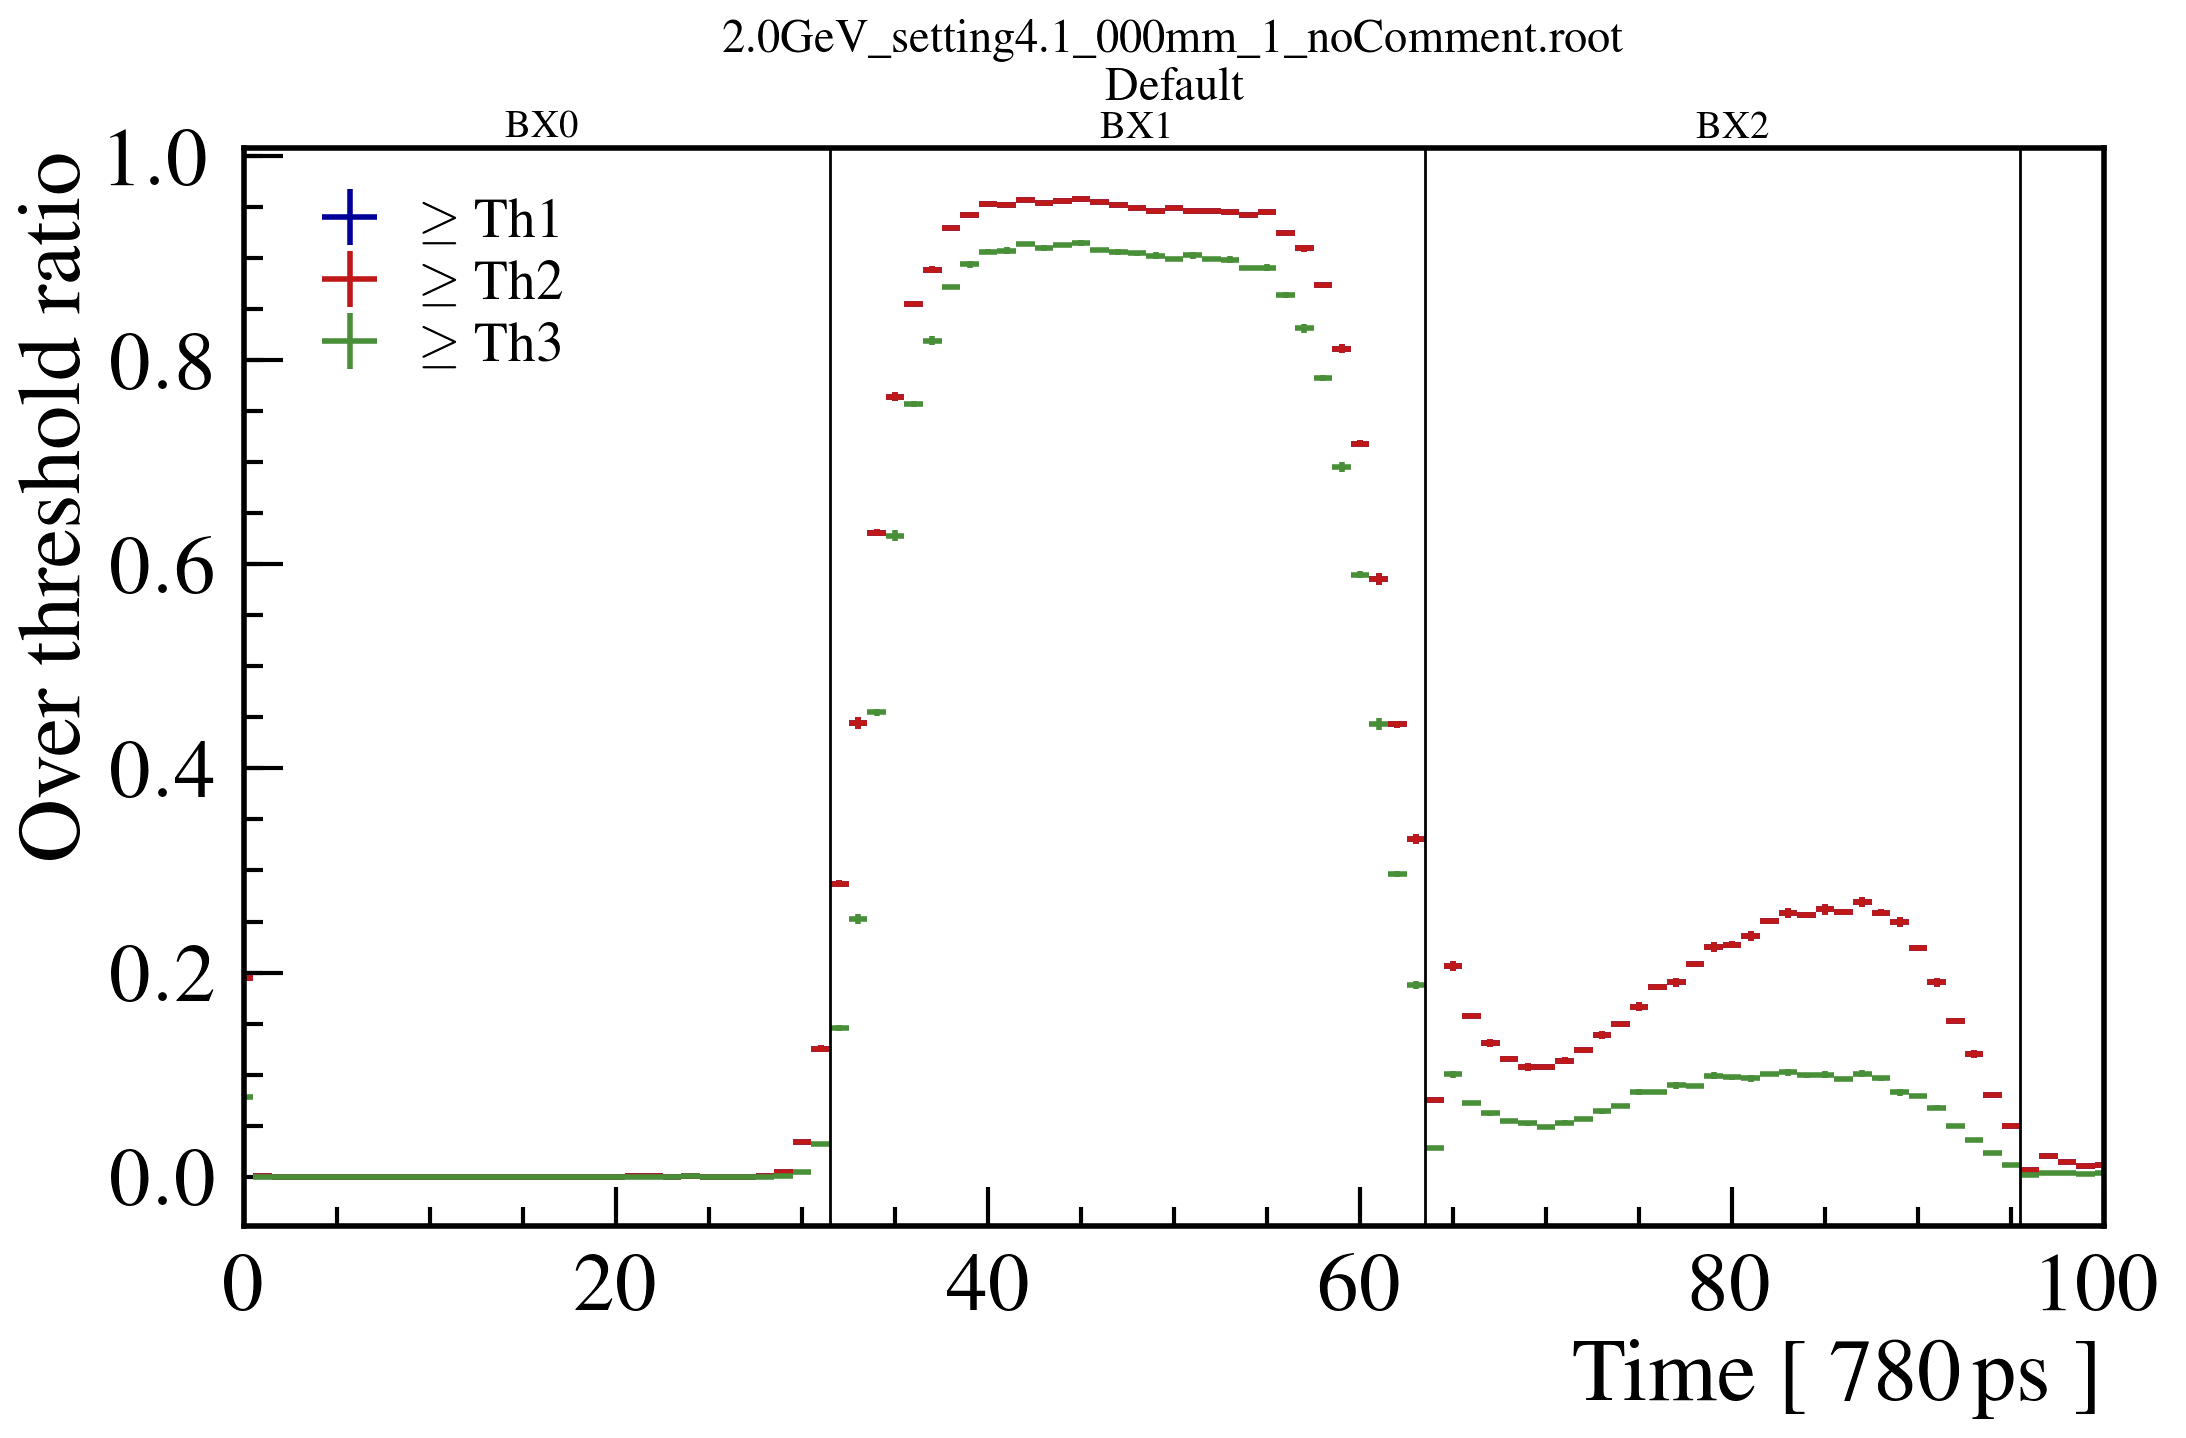

Saved 2.0GeV_setting4.1_000mm_1_noComment.root, Default to Plots/Signalshape_clusterchannels/Signalshape.pdf


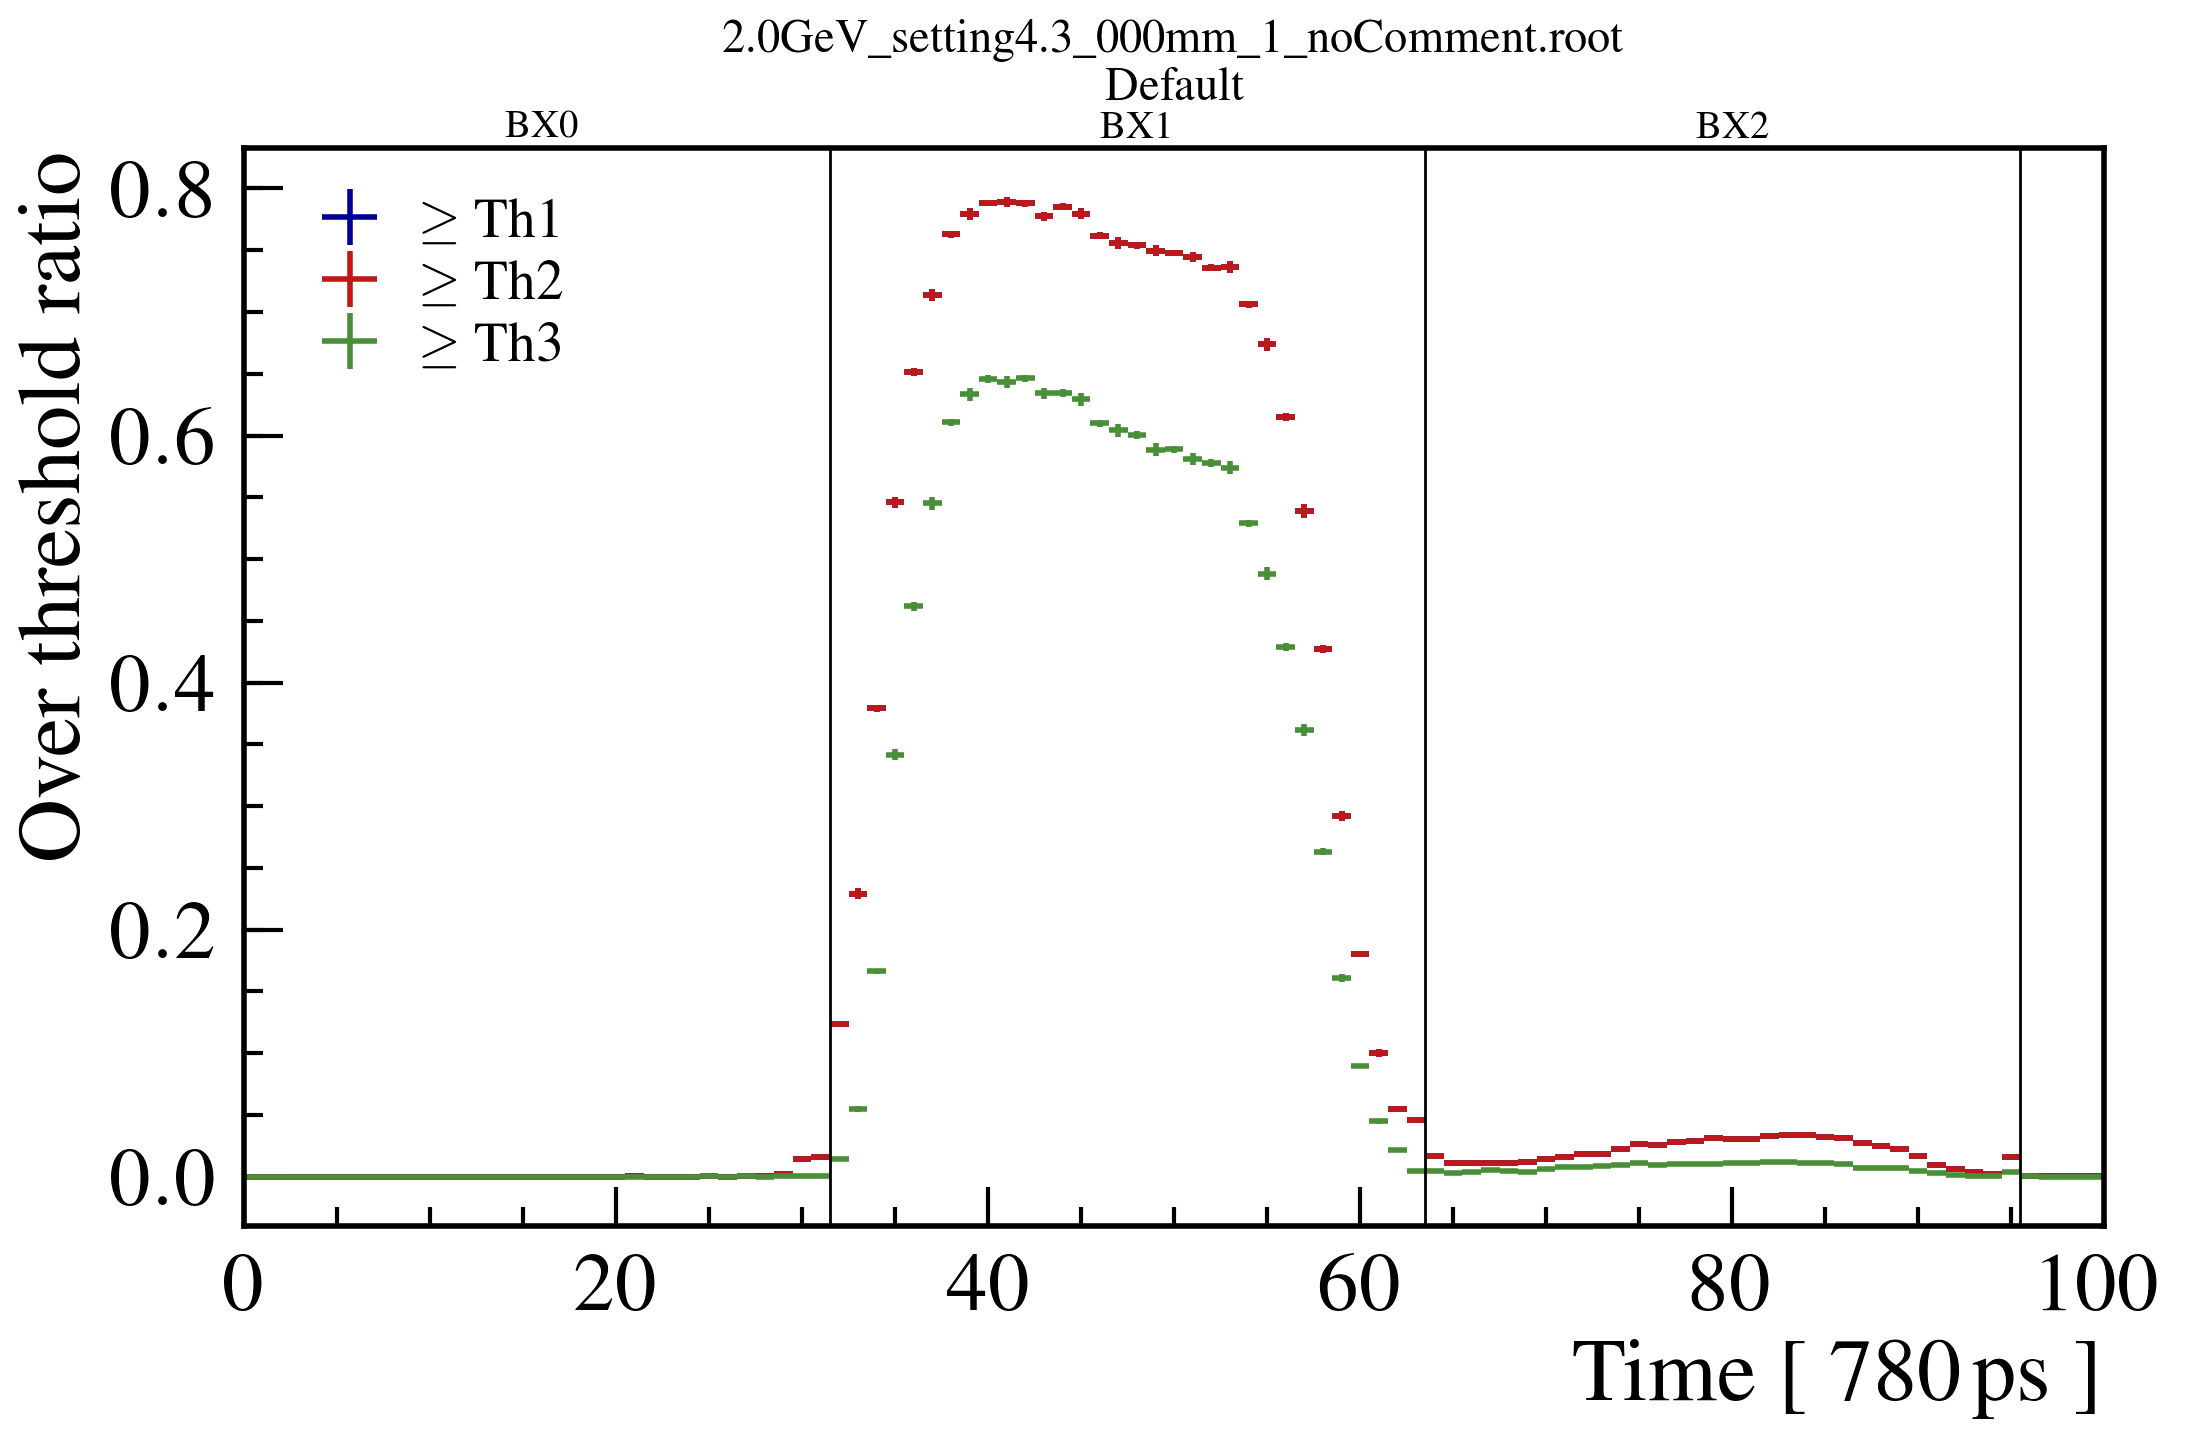

Saved 2.0GeV_setting4.3_000mm_1_noComment.root, Default to Plots/Signalshape_clusterchannels/Signalshape.pdf
Finished


In [59]:
filename = "Plots/Signalshape_clusterchannels/Signalshape.pdf"
channels = range(64)

STUDENT.ensure_dir(os.path.dirname(filename))
pp = PdfPages(filename)

for index, row in DF_selected_files.iterrows():
    DF = row.loc["Dataframe"]
    for algorithm in cluster_algorithms:
        plt.figure(figsize=(12,7))
        #Filter channel_matrix according to clusters
        channel_matrix = DF[["Ch_{}".format(ch) for ch in channels]].values
        rounded_cluster_positions = [ [int(round(cluster.Position())) for cluster in evt_clusters] 
                                     for evt_clusters in DF["Clusters_"+algorithm] ]
        for i in range(len(channel_matrix)):
            mask = np.ones(len(channels), dtype=bool)
            try:
                mask[rounded_cluster_positions[i]] = False
            except IndexError:
                print(i, rounded_cluster_positions[i])
                raise
                
            channel_matrix[i, mask] = 0  #Set all channels not in centrum of clusters to zero
            
        for Th in [1,2,3]:
            pacific_signal, time, errlow, errup = TB.signalshape(DF["BXing"], DF["Finetiming"], 
                                                                 channel_matrix, Th)

            dpl.errorbar(np.asarray(time[:-1]), pacific_signal, xerr=0.5, yerr=[errlow,errup], fmt=".", ms=0, 
                         label="$\geq$ Th{}".format(Th))

        plt.xlim(0,100)
        TB.plot_BX_overlay()
        plt.legend(fontsize=20)

        dpl.xlabel(r"Time [ $\SI{780}{ps}$ ]")
        dpl.ylabel("Over threshold ratio")
        plt.title(row["Filename_short"].replace("_", "\_")+"\n"+algorithm, y=1.03)
        pp.savefig()
        plt.show()
        print("Saved {}, {} to {}".format(row["Filename_short"], algorithm, filename))
        plt.close()

pp.close()
print("Finished")